In [45]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
vel01 = pd.read_csv('data/VDS_지점통행속도_5분_1일_20240601.csv',encoding='cp949')
vel01 = vel01.iloc[:,[2,1,5]]
vel01 = vel01.rename(columns={'집계시분':'time','평균속도':'avgVel'})
vel01 = vel01.sort_values(by=['VDS_ID','time'], ignore_index=True)
vel01.head()

,VDS_ID,time,avgVel
0,0010VDE00100,00:00,83.26
1,0010VDE00100,00:05,84.60
2,0010VDE00100,00:10,88.46
3,0010VDE00100,00:15,86.53
4,0010VDE00100,00:20,93.66


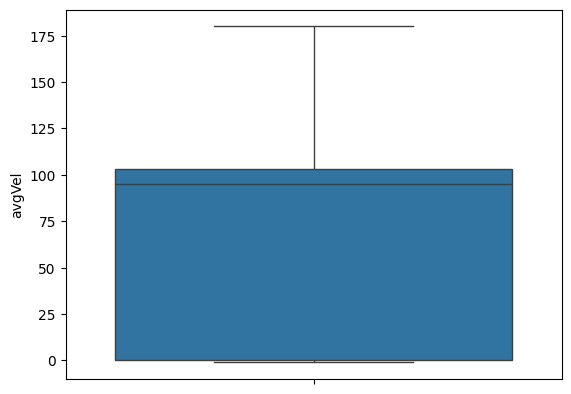

In [3]:
# draw box plot of avgVel
sns.boxplot(y='avgVel', data=vel01)
plt.show()

In [9]:
np.sort(vel01['avgVel'].unique())

array([ -1.,   0.,   1., ..., 178., 179., 180.])

Missing values with the value of -1. need dropping. Check maximum speed on Korean highways.

In [11]:
limit = pd.read_csv('data/고속도로 구간별 제한속도(2024년4월).csv', encoding='cp949')
limit.head()

,노선명,시점부,종점부,구간길이,기점 방향 제한속도(kph),종점 방향 제한속도(kph)
0,경부선,구서IC,언양JCT,39.51,100,100
1,경부선,언양JCT,영천IC,56.28,100,100
2,경부선,영천IC,옥천휴게소 부근,157.70,100,100
3,경부선,옥천휴게소 부근,옥천IC 인근,3.50,100,100
4,경부선,옥천IC 인근,천안IC,75.80,100,100


In [12]:
print(limit['기점 방향 제한속도(kph)'].unique())
print(limit['종점 방향 제한속도(kph)'].unique())

[100 110  80]
[100 110  80]


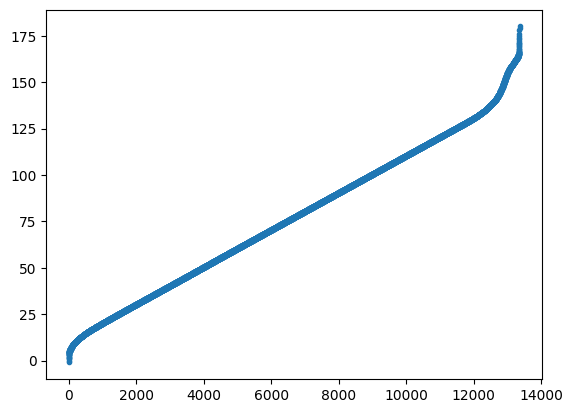

In [16]:
plt.plot(np.sort(vel01['avgVel'].unique()),'.')
plt.show()

In [17]:
np.percentile(vel01['avgVel'],75)

np.float64(103.31)

In [29]:
# drop data whose velocity is equal to -1.0, 0.0 or larger than 110
# slice the data
data = []
vds = vel01['VDS_ID'].unique()
for i in range(len(vds)):
    data.append(vel01['avgVel'].values[288*i:288*(i+1)])
data = np.array(data)
bMask = [np.any((elem!=-1.0)&(elem!=-0.0)&(elem<=110)) for elem in data]
data = data[bMask]
print(len(data))
data

6779


array([[ 83.26,  84.6 ,  88.46, ...,  87.58,  85.14,  85.15],
       [100.93,  98.47, 104.68, ...,  95.99,  98.77,  98.28],
       [ 92.78,  88.06,  97.13, ...,  89.19,  89.52,  92.4 ],
       ...,
       [101.85,  97.65,  97.2 , ..., 103.8 , 102.95, 105.75],
       [106.85, 102.3 , 101.45, ..., 109.3 , 113.  , 109.1 ],
       [115.4 , 110.45, 105.4 , ..., 109.7 , 110.78, 103.95]])

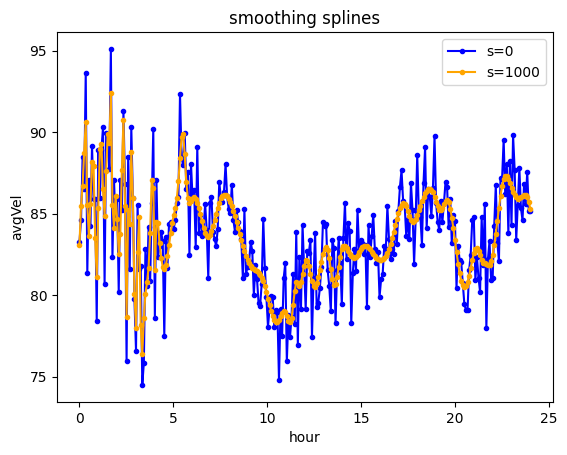

In [38]:
# data cleaning - remove the noise by smoothing
from scipy.interpolate import splrep, BSpline
h = np.linspace(0,24,288)
tck = splrep(h, data[0], s=1000)
plt.plot(h, data[0],'.-',color='blue', label='s=0')
plt.plot(h, BSpline(*tck)(h), '.-',color='orange',label='s=1000')
plt.xlabel('hour')
plt.ylabel('avgVel')
plt.title('smoothing splines')
plt.legend()
plt.show()

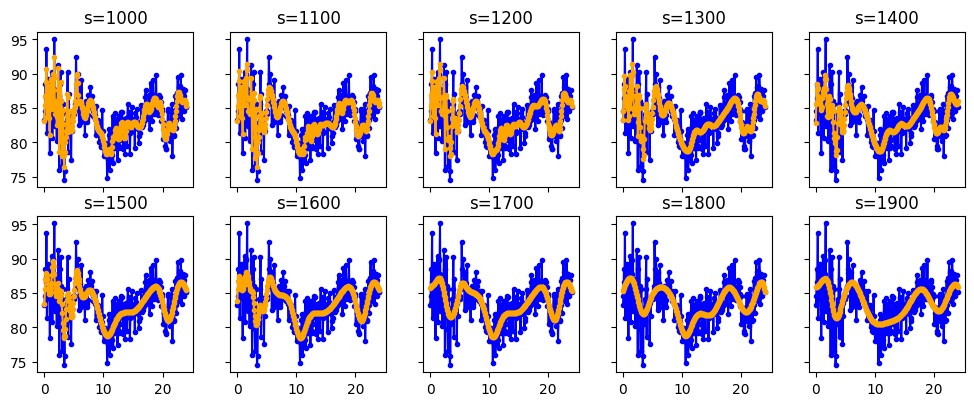

In [44]:
h = np.linspace(0,24,288)
y = []
test_s = list(range(1000,2000,100))

for i in test_s:
    temp_tick = splrep(h, data[0], s=i)
    y.append(BSpline(*temp_tick)(h))

# plot them all
row = 2
col = 5
fig, axs = plt.subplots(row,col,sharex=True, sharey=True,figsize=(10,4))
plt.tight_layout()
for i in range(row):
    for j in range(col):
        axs[i][j].plot(h, data[0],'.-',color='blue', label='s=0')
        axs[i][j].plot(h, y[col*i+j],'.-',color='orange',label='s=270')
        axs[i][j].set_title(f"s={test_s[col*i+j]}")      

In [74]:
# turning back to our data, apply this method to each element of data
data_sp = []
for i in range(len(data)):
    tck = splrep(h, data[i], s=3000)
    data_sp.append(BSpline(*tck)(h))

C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_fitpack_py.py:295: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


In [75]:
scaler = MinMaxScaler()
data_sp = np.array(data)
scaled_data = scaler.fit_transform(data_sp.reshape(-1,1))
scaled_data = scaled_data.reshape(6779,288)

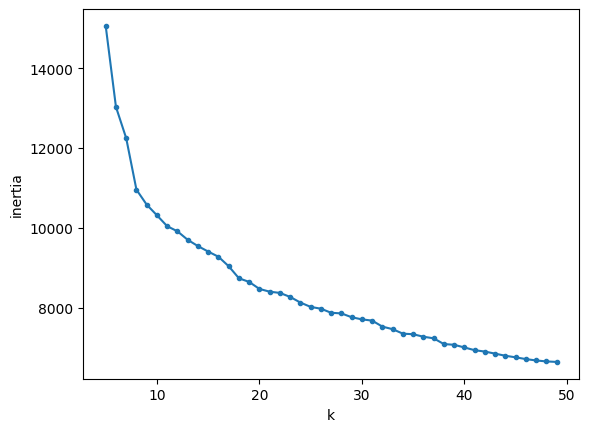

In [76]:
# find the best k for K-Means alg
inertia = []
for k in range(5,50):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# find an elbow by plotting values of inertia
plt.plot(range(5,50),inertia,'.-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

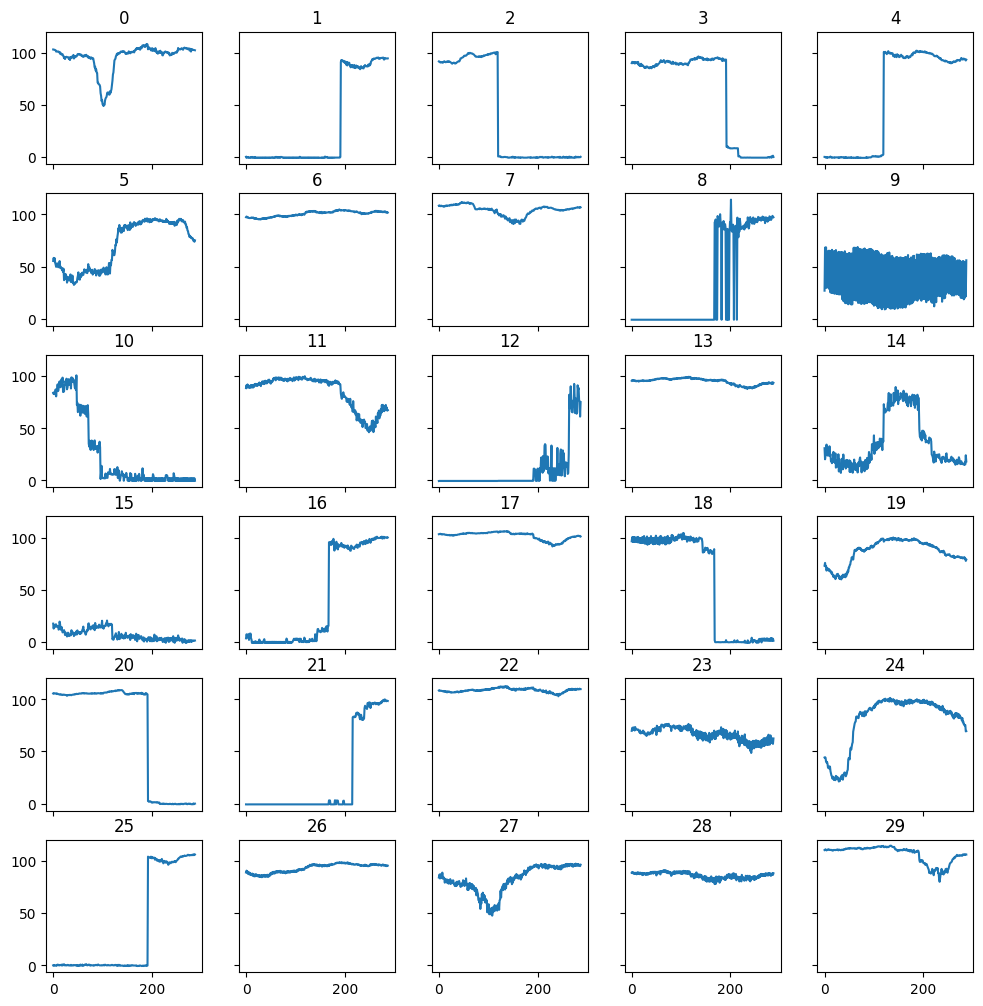

In [78]:
# k=30
def draw_pattern(arr):
    row = int(np.ceil(len(arr)/5))
    col = 5
    fig, axs = plt.subplots(row,col,sharex=True, sharey=True, figsize=(10,10))
    plt.tight_layout()
    for i in range(row):
        for j in range(col):
            if i*col + j < len(arr):
                axs[i][j].plot(range(len(arr[col*i+j])), arr[col*i+j])
                axs[i][j].set_title(col*i+j)
    plt.savefig('KM50.png')

km30 = KMeans(n_clusters=30, random_state=42)
km30.fit(data)
# draw cluster centers
draw_pattern(km30.cluster_centers_)

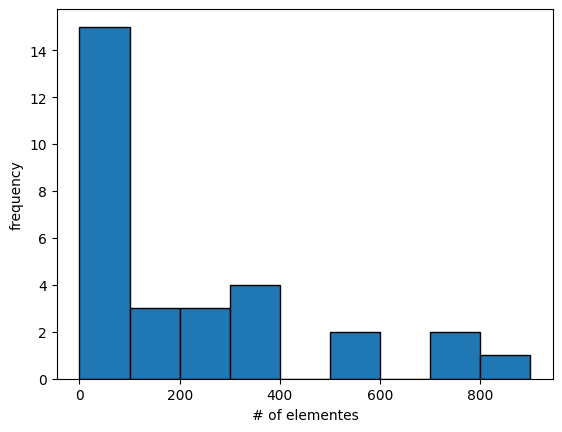

In [103]:
# check a balance between clusters
cluster_num = list(len(scaled_data[km30.labels_==i]) for i in range(30))
plt.hist(cluster_num, edgecolor='k',bins=[100*i for i in range(10)])
plt.xlabel('# of elementes')
plt.ylabel('frequency')
plt.show()

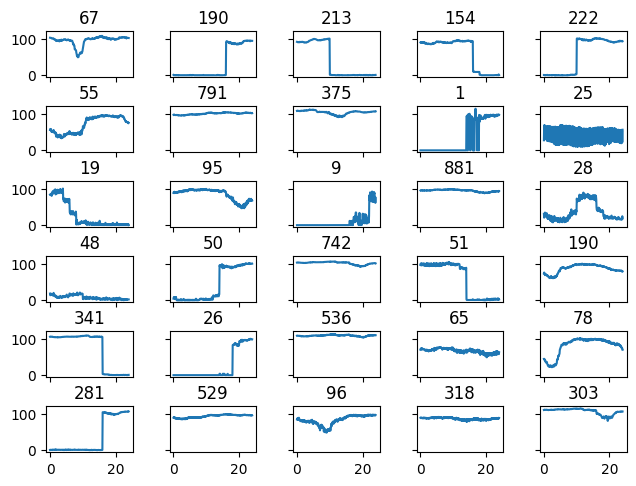

In [92]:
# take the number of elements of clusters as titles
arr = km30.cluster_centers_
row = int(np.ceil(len(arr)/5))
col = 5
fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
plt.tight_layout()
for i in range(row):
    for j in range(col):
        if i*col + j < len(arr):
            axs[i][j].plot(h, arr[col*i+j])
            axs[i][j].set_title(cluster_num[col*i+j])

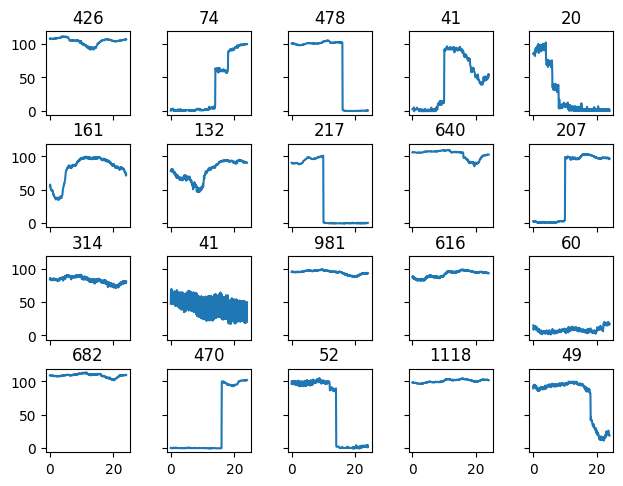

In [91]:
# better reduce k
# k=20
km20 = KMeans(n_clusters=20, random_state=42)
km20.fit(data)
cluster_num20 = list(len(scaled_data[km20.labels_==i]) for i in range(20))

# take the number of elements of clusters as titles
arr = km20.cluster_centers_
row = int(np.ceil(len(arr)/5))
col = 5
fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
plt.tight_layout()
for i in range(row):
    for j in range(col):
        if i*col + j < len(arr):
            axs[i][j].plot(h, arr[col*i+j])
            axs[i][j].set_title(cluster_num20[col*i+j])

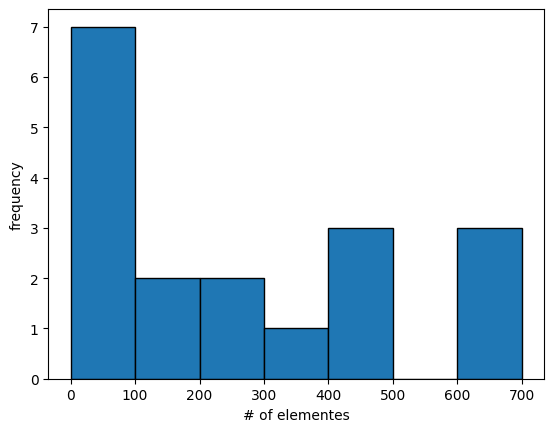

In [105]:
# check a balance between clusters
plt.hist(cluster_num20, edgecolor='k',bins=[100*i for i in range(8)])
plt.xlabel('# of elementes')
plt.ylabel('frequency')
plt.show()